In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import resnet, vit_l_16
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import tqdm
import wandb

cudnn.benchmark = True
plt.ion()

In [2]:
data_transforms = {
    'train_val': transforms.Compose([
        transforms.RandomRotation(180),
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.RandomApply(
            [transforms.GaussianBlur(kernel_size=5)],
            p=0.5
        ),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/synthetic'
image_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train_val'])
class_names = image_dataset.classes
# split the dataset into train and validation sets
# train: 0.8, validation: 0.1, test: 0.1
train_size = int(0.8 * len(image_dataset))
val_size = int(0.1 * len(image_dataset))
test_size = len(image_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size, test_size])
real_data_dir = 'data/real'
real_image_dataset = datasets.ImageFolder(real_data_dir, transform=data_transforms['test'], allow_empty=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4)
real_loader = torch.utils.data.DataLoader(real_image_dataset, batch_size=16, shuffle=True, num_workers=4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# print the size of each dataset
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")
print(f"Real size: {len(real_image_dataset)}")

num_epochs = 35


Train size: 7194
Validation size: 899
Test size: 900
Real size: 73


In [17]:
print(class_names)

['Plate1x1(3024)', 'Plate1x10(4477)', 'Plate1x12(60479)', 'Plate1x2(3023)', 'Plate1x3(3623)', 'Plate1x4(3710)', 'Plate1x5(78329)', 'Plate1x6(3666)', 'Plate1x8(3460)', 'Plate2x10(3832)', 'Plate2x12(2445)', 'Plate2x14(91988)', 'Plate2x16(4282)', 'Plate2x2(3022)', 'Plate2x2Corner(2420)', 'Plate2x3(3021)', 'Plate2x4(3020)', 'Plate2x6(3795)', 'Plate2x8(3034)', 'Plate3x3(11212)', 'Plate3x3Corner(77844)', 'Plate4x10(3030)', 'Plate4x12(3029)', 'Plate4x4(3031)', 'Plate4x4Corner(2639)', 'Plate4x6(3032)', 'Plate4x8(3035)', 'Plate6x10(3033)', 'Plate6x12(3028)', 'Plate6x14(3456)', 'Plate6x16(3027)', 'Plate6x24(3026)', 'Plate6x6(3958)', 'Plate6x8(3036)', 'Plate8x16(92438)', 'Plate8x8(42534)']


In [3]:
wandb.init(
    project='lego-classification',
    entity='lego-classification',
    config={
        'model': 'vit_l_16',
        'optimizer': 'SGD',
        'scheduler': 'StepLR',
        'num_epochs': num_epochs,
        'batch_size': 16,
        'train_size': len(train_dataset),
        'val_size': len(val_dataset),
        'test_size': len(test_dataset),
    }
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: elliott-song (lego-classification). Use `wandb login --relogin` to force relogin


In [18]:
# set the model if it is available
previous_model = 'models/BestModel.pth'

# Load a pretrained model and reset final fully connected layer.
model = models.vit_l_16(weights=models.ViT_L_16_Weights.IMAGENET1K_SWAG_LINEAR_V1)
# adapt the model to our dataset - change the number of classes
model.head = nn.Linear(model.num_classes, len(class_names))

model = model.to(device)


if previous_model and os.path.exists(previous_model):
    # load the state dict
    model.load_state_dict(torch.load(previous_model))
    print("Loaded the previous model")

# Set the model to training mode
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002)
# Decay LR by a factor of 0.1 every 8 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.2)

# description of the model
print(model)

C:\Users\Elliott\AppData\Local\Temp\ipykernel_14780\3030436296.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(previous_model))


TypeError: Expected state_dict to be dict-like, got <class 'torchvision.models.vision_transformer.VisionTransformer'>.

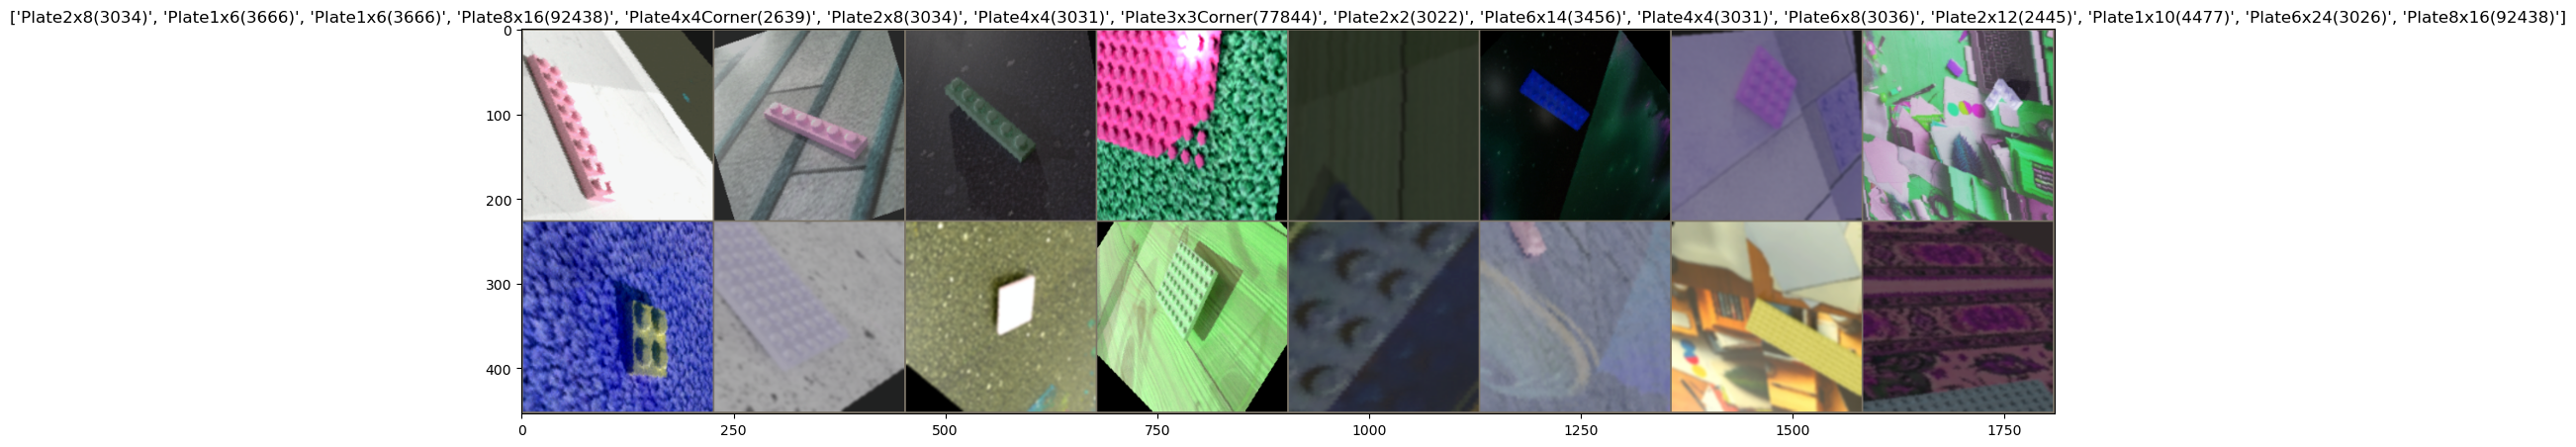

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    # show the image with resolution 224x224
    plt.figure(figsize=(20, 20))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

wandb.log({"examples": [wandb.Image(out)]})

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_acc = 0.0

    with TemporaryDirectory() as tempdir:
        model_dir = os.path.join(tempdir, 'model')
        torch.save(model.state_dict(), model_dir)

        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch + 1, num_epochs))
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                    dataloader = train_loader
                else:
                    model.eval()
                    dataloader = val_loader

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                loop = tqdm.tqdm(enumerate(dataloader), total=len(dataloader), leave=False)
                for batch, (inputs, labels) in loop:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    loop.set_description(f'Epoch [{epoch + 1}/{num_epochs}]')
                    loop.set_postfix(loss=running_loss / len(dataloader.dataset), acc=running_corrects.double() / len(dataloader.dataset))

                epoch_loss = running_loss / len(dataloader.dataset)
                epoch_acc = running_corrects.double() / len(dataloader.dataset)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                wandb.log({f'{phase}_loss': epoch_loss, f'{phase}_acc': epoch_acc}, step=epoch+1)

                if phase == 'val':
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        torch.save(model.state_dict(), model_dir)

                if phase == 'train':
                    scheduler.step()
                    print(f'Learning rate: {scheduler.get_last_lr()}')

            print()
            
        model.load_state_dict(torch.load(model_dir))

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    return model


In [7]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

Epoch 1/35
----------


train Loss: 3.8427 Acc: 0.0293
Learning rate: [0.002]


val Loss: 3.6584 Acc: 0.0345

Epoch 2/35
----------


train Loss: 3.4862 Acc: 0.0502
Learning rate: [0.002]


val Loss: 3.1276 Acc: 0.0845

Epoch 3/35
----------


train Loss: 2.9838 Acc: 0.1202
Learning rate: [0.002]


val Loss: 2.6822 Acc: 0.1824

Epoch 4/35
----------


train Loss: 2.4849 Acc: 0.2284
Learning rate: [0.002]


val Loss: 1.9785 Acc: 0.3493

Epoch 5/35
----------


train Loss: 2.1240 Acc: 0.3086
Learning rate: [0.002]


val Loss: 1.9444 Acc: 0.3637

Epoch 6/35
----------


train Loss: 1.9428 Acc: 0.3582
Learning rate: [0.002]


val Loss: 2.2765 Acc: 0.2870

Epoch 7/35
----------


train Loss: 1.8886 Acc: 0.3782
Learning rate: [0.002]


val Loss: 1.7523 Acc: 0.4105

Epoch 8/35
----------


train Loss: 1.7657 Acc: 0.4055
Learning rate: [0.0004]


val Loss: 2.2089 Acc: 0.3103

Epoch 9/35
----------


train Loss: 1.3239 Acc: 0.5632
Learning rate: [0.0004]


val Loss: 1.2044 Acc: 0.5918

Epoch 10/35
----------


train Loss: 1.2118 Acc: 0.5949
Learning rate: [0.0004]


val Loss: 1.1976 Acc: 0.6007

Epoch 11/35
----------


train Loss: 1.1649 Acc: 0.6076
Learning rate: [0.0004]


val Loss: 1.2243 Acc: 0.5628

Epoch 12/35
----------


train Loss: 1.1483 Acc: 0.6116
Learning rate: [0.0004]


val Loss: 1.2052 Acc: 0.6196

Epoch 13/35
----------


train Loss: 1.1148 Acc: 0.6277
Learning rate: [0.0004]


val Loss: 1.2062 Acc: 0.5895

Epoch 14/35
----------


train Loss: 1.0912 Acc: 0.6333
Learning rate: [0.0004]


val Loss: 1.1656 Acc: 0.6151

Epoch 15/35
----------


train Loss: 1.0850 Acc: 0.6327
Learning rate: [0.0004]


val Loss: 1.1641 Acc: 0.6107

Epoch 16/35
----------


train Loss: 1.0866 Acc: 0.6357
Learning rate: [8e-05]


val Loss: 1.1928 Acc: 0.6062

Epoch 17/35
----------


train Loss: 1.0121 Acc: 0.6625
Learning rate: [8e-05]


val Loss: 0.9983 Acc: 0.6596

Epoch 18/35
----------


train Loss: 0.9989 Acc: 0.6675
Learning rate: [8e-05]


val Loss: 1.1043 Acc: 0.6340

Epoch 19/35
----------


train Loss: 0.9874 Acc: 0.6714
Learning rate: [8e-05]


val Loss: 1.0481 Acc: 0.6618

Epoch 20/35
----------


train Loss: 0.9774 Acc: 0.6774
Learning rate: [8e-05]


val Loss: 1.0221 Acc: 0.6618

Epoch 21/35
----------


train Loss: 0.9655 Acc: 0.6817
Learning rate: [8e-05]


val Loss: 1.0379 Acc: 0.6552

Epoch 22/35
----------


train Loss: 0.9596 Acc: 0.6786
Learning rate: [8e-05]


val Loss: 1.0678 Acc: 0.6440

Epoch 23/35
----------


train Loss: 0.9592 Acc: 0.6829
Learning rate: [8e-05]


val Loss: 1.0879 Acc: 0.6263

Epoch 24/35
----------


train Loss: 0.9537 Acc: 0.6858
Learning rate: [1.6000000000000003e-05]


val Loss: 1.0961 Acc: 0.6318

Epoch 25/35
----------


train Loss: 0.9524 Acc: 0.6846
Learning rate: [1.6000000000000003e-05]


val Loss: 1.0615 Acc: 0.6340

Epoch 26/35
----------


train Loss: 0.9398 Acc: 0.6904
Learning rate: [1.6000000000000003e-05]


val Loss: 0.9782 Acc: 0.6630

Epoch 27/35
----------


train Loss: 0.9303 Acc: 0.6925
Learning rate: [1.6000000000000003e-05]


val Loss: 1.0885 Acc: 0.6496

Epoch 28/35
----------


train Loss: 0.9281 Acc: 0.6947
Learning rate: [1.6000000000000003e-05]


val Loss: 1.0039 Acc: 0.6652

Epoch 29/35
----------


train Loss: 0.9349 Acc: 0.6903
Learning rate: [1.6000000000000003e-05]


val Loss: 1.0504 Acc: 0.6507

Epoch 30/35
----------


train Loss: 0.9527 Acc: 0.6838
Learning rate: [1.6000000000000003e-05]


val Loss: 1.0605 Acc: 0.6452

Epoch 31/35
----------


train Loss: 0.9336 Acc: 0.6921
Learning rate: [1.6000000000000003e-05]


val Loss: 1.0749 Acc: 0.6340

Epoch 32/35
----------


train Loss: 0.9342 Acc: 0.6915
Learning rate: [3.2000000000000007e-06]


val Loss: 1.0835 Acc: 0.6396

Epoch 33/35
----------


train Loss: 0.9279 Acc: 0.6959
Learning rate: [3.2000000000000007e-06]


val Loss: 1.0411 Acc: 0.6474

Epoch 34/35
----------


train Loss: 0.9071 Acc: 0.7024
Learning rate: [3.2000000000000007e-06]


val Loss: 1.0477 Acc: 0.6652

Epoch 35/35
----------


train Loss: 0.9149 Acc: 0.6977
Learning rate: [3.2000000000000007e-06]


C:\Users\Elliott\AppData\Local\Temp\ipykernel_14780\948577013.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_dir))


val Loss: 1.0166 Acc: 0.6541

Training complete in 319m 35s
Best val Acc: 0.665184


In [8]:
# save the model
model_name = 'NewAttempt.pth'
torch.save(model, model_name)

In [9]:
# save the model to wandb
wandb.save(model_name)

[]

In [10]:
# test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    loop = tqdm.tqdm(enumerate(test_loader), total=len(test_loader), leave=False)
    for batch, data in loop:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loop.set_description(f"Batch {batch}: {correct}/{total} (Acc: {correct/total:.2f})")
    
wandb.log({"test_acc": correct / total, "test_correct": correct, "test_total": total})
print(f"Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%")

# test on real images
model.eval()
correct = 0
total = 0
my_table = wandb.Table(columns=["image", "true", "predicted"])
with torch.no_grad():
    loop = tqdm.tqdm(enumerate(real_loader), total=len(real_loader), leave=False)
    for batch, data in loop:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        print(f"Number of images: {len(images)}, Number of labels: {len(labels)}, Number of predicted: {len(predicted)}")
        for i in range(len(labels)):
            my_table.add_data(wandb.Image(images[i], caption=f"true: {class_names[labels[i]]}, pred: {class_names[predicted[i]]}"), class_names[labels[i]], class_names[predicted[i]])
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loop.set_description(f"Batch {batch}: {correct}/{total} (Acc: {correct/total:.2f})")
print(f"Accuracy of the network on the {total} real images: {100 * correct / total:.2f}%")
wandb.log({"real_acc": correct / total, "real_correct": correct, "real_total": total})
print(f"Logging the real images")
wandb.log({"real_table": my_table})
print(f"Logged the real images")

Accuracy of the network on the 900 test images: 63.22%


  0%|          | 0/5 [00:00<?, ?it/s]

Number of images: 16, Number of labels: 16, Number of predicted: 16


Batch 0: 14/16 (Acc: 0.88):  20%|██        | 1/5 [00:04<00:16,  4.12s/it]

Number of images: 16, Number of labels: 16, Number of predicted: 16


Batch 1: 28/32 (Acc: 0.88):  40%|████      | 2/5 [00:04<00:06,  2.09s/it]

Number of images: 16, Number of labels: 16, Number of predicted: 16


Batch 2: 44/48 (Acc: 0.92):  60%|██████    | 3/5 [00:05<00:02,  1.44s/it]

Number of images: 16, Number of labels: 16, Number of predicted: 16


Batch 3: 58/64 (Acc: 0.91):  80%|████████  | 4/5 [00:06<00:01,  1.14s/it]

Number of images: 9, Number of labels: 9, Number of predicted: 9


Accuracy of the network on the 73 real images: 91.78%
Logging the real images
Logged the real images


In [15]:
print(my_table)
wandb.log({"real_table": my_table})

In [16]:
wandb.finish()

real_acc,▁
real_correct,▁
real_total,▁
test_acc,▁
test_correct,▁
test_total,▁
train_acc,▁▁▂▃▄▄▅▅▇▇▇▇▇▇▇▇███████████████████
train_loss,█▇▆▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▃▄▅▄▅▄▇▇▇▇▇▇▇▇███████████████████
val_loss,█▇▅▄▄▄▃▄▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
real_acc,0.91781
